In [11]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert to DataFrame
df = pd.read_csv("output.csv")

In [12]:
df

,timestep,bodyIndex,x,y,z,vx,vy,vz
0,0,0,5.772460e-02,-9.926040e-04,-1.728510e-04,0.000115,-0.000002,-3.457020e-07
1,0,1,4.390040e+10,-4.353940e+10,-7.584730e+09,24646.600000,36893.500000,7.543610e+02
2,0,2,1.496000e+11,1.489000e+07,-2.777770e-05,-2.965830,29780.000000,-5.555540e-08
3,0,3,7.785000e+11,6.535000e+06,-1.048470e-07,-0.109526,13070.000000,-2.096940e-10
4,1,0,1.731740e-01,-2.976710e-03,-5.185800e-04,0.000231,-0.000004,-6.914570e-07
...,...,...,...,...,...,...,...,...
95995,23998,3,7.627820e+11,1.557770e+11,-1.728740e+01,-2610.750000,12806.100000,-2.014320e-06
95996,23999,0,1.584710e+07,1.846890e+06,-2.512050e+02,2.555300,0.419846,8.624990e-04
95997,23999,1,-5.703210e+10,-2.786020e+10,2.955600e+09,11312.400000,-41677.200000,-4.443340e+03
95998,23999,2,-1.092710e+11,1.019020e+11,-1.192770e+03,-20321.600000,-21813.900000,2.627120e-04


Creating frames: 100%|█████████▉| 199/200 [55:15<00:16, 16.66s/frame]
/var/folders/2w/ghmwyjw93f9_6hhm7fwqnfc00000gn/T/ipykernel_50394/2820511626.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('hsv', num_bodies)
Creating frames: 100%|█████████▉| 199/200 [00:04<00:00, 39.86frame/s]

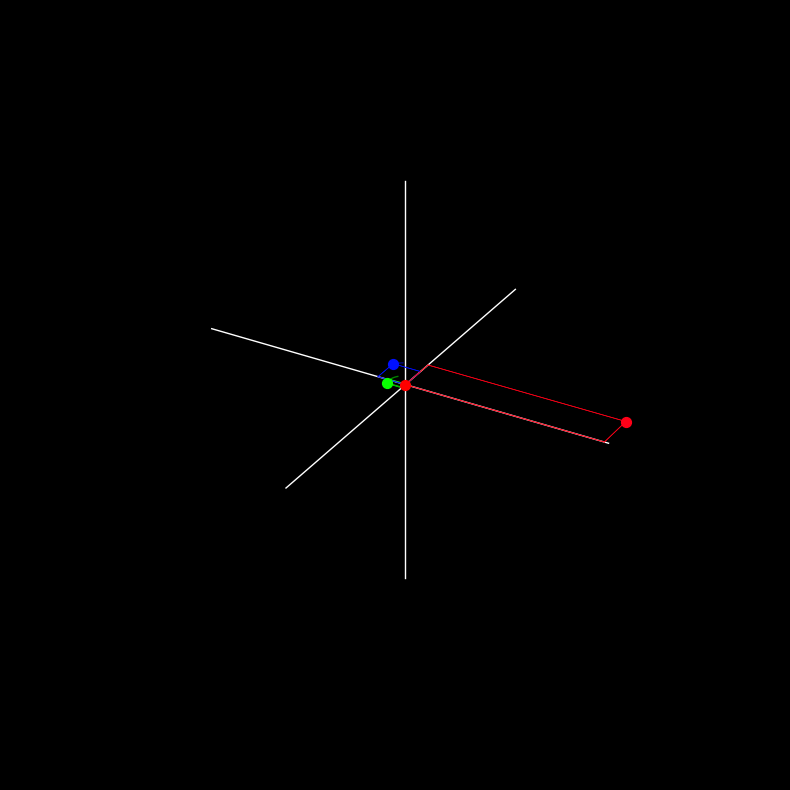

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
from tqdm import tqdm  # For progress bar
import matplotlib.cm as cm  # For colormap

# --- Step 1: Ensure 'df' is Available ---
# Assuming 'df' is already loaded and has the following structure:
# Columns: 'timestep', 'bodyIndex', 'x', 'y', 'z', 'vx', 'vy', 'vz'

# Convert 'z' and 'vz' to float for consistency
df['z'] = df['z'].astype(float)
df['vz'] = df['vz'].astype(float)

# --- Step 2: Set Animation Parameters ---
fps = 20  # Frames per second
duration = 10  # Duration in seconds
total_frames = fps * duration  # Total number of frames

# Select a subset of timesteps to fit within the total_frames
unique_timesteps = sorted(df['timestep'].unique())
frame_interval = max(1, len(unique_timesteps) // total_frames)
timestep_range = unique_timesteps[::frame_interval]

# Ensure we have exactly total_frames
if len(timestep_range) > total_frames:
    timestep_range = timestep_range[:total_frames]

# --- Step 3: Center the Plot at bodyIndex 0 ---
initial_timestep = df['timestep'].min()
body0_initial = df[df['timestep'] == initial_timestep].iloc[0][['x', 'y', 'z']]

# Shift all positions so that bodyIndex 0 is at the origin
df_shifted = df.copy()
df_shifted[['x', 'y', 'z']] = df[['x', 'y', 'z']] - body0_initial

# --- Step 4: Assign Unique Colors to Each Body ---
# Determine the number of unique bodies
unique_bodies = df_shifted['bodyIndex'].unique()
num_bodies = len(unique_bodies)

# Assign a unique color to each body using a colormap
colors = cm.get_cmap('hsv', num_bodies)
body_colors = {body: colors(i) for i, body in enumerate(unique_bodies)}

# --- Step 5: Determine Axis Ranges ---
# Determine axis ranges based on shifted data
x_min, x_max = df_shifted['x'].min(), df_shifted['x'].max()
y_min, y_max = df_shifted['y'].min(), df_shifted['y'].max()
z_min, z_max = df_shifted['z'].min(), df_shifted['z'].max()

# Use the maximum absolute range for symmetry
max_range = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max), abs(z_min), abs(z_max))
# max_range = 778500000

# --- Step 6: Create the Figure and 3D Axes ---
fig = plt.figure(figsize=(8, 8), facecolor='black', tight_layout=True)
ax = fig.add_subplot(111, projection='3d', facecolor='black')

# Set equal axis limits
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Remove axes, gridlines, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.grid(False)
ax.axis('off')  # Completely turn off the axis

# Set equal aspect ratio (requires Matplotlib >= 3.3.0)
try:
    ax.set_box_aspect([1,1,1])
except AttributeError:
    pass  # For older Matplotlib versions, skip aspect ratio setting

# --- Step 7: Plot White X, Y, Z Axes ---
# Plot X-axis
ax.plot([-max_range, max_range], [0, 0], [0, 0], color='white', linewidth=1)
# Plot Y-axis
ax.plot([0, 0], [-max_range, max_range], [0, 0], color='white', linewidth=1)
# Plot Z-axis
ax.plot([0, 0], [0, 0], [-max_range, max_range], color='white', linewidth=1)

# --- Step 8: Initialize Scatter Points, Connecting Lines, and Trailing Lines ---
# Prepare dictionaries to hold scatter points, connecting lines, and trailing lines for each body
scatter_points = {}
lines = {}
trail_lines = {}
position_history = {body: [] for body in unique_bodies}  # Initialize position history for each body

# Define the maximum trail length (e.g., 50 frames)
trail_length = 20

for body in unique_bodies:
    # Initialize scatter points (empty)
    scatter_points[body] = ax.scatter([], [], [], color=body_colors[body], s=50)
    
    # Initialize connecting lines for the box with 12 edges, same color as the body
    lines[body] = [ax.plot([], [], [], color=body_colors[body], linewidth=0.5)[0] for _ in range(12)]
    
    # Initialize the trailing line for each body
    trail_lines[body], = ax.plot([], [], [], color=body_colors[body], linewidth=1, alpha=0.5)

# --- Step 9: Define the Update Function ---
def update_plot(timestep):
    # Filter data for the current timestep
    timestep_data = df_shifted[df_shifted['timestep'] == timestep]
    
    for _, row in timestep_data.iterrows():
        body = row['bodyIndex']
        x, y, z = row['x'], row['y'], row['z']
        
        # Update scatter point position
        scatter_points[body]._offsets3d = ([x], [y], [z])
        
        # Append the new position to the history, and limit its length to `trail_length`
        position_history[body].append((x, y, z))
        if len(position_history[body]) > trail_length:
            position_history[body].pop(0)  # Remove oldest position if history exceeds trail_length
        
        # Update trail line with the history of positions
        trail_x, trail_y, trail_z = zip(*position_history[body])
        trail_lines[body].set_data(trail_x, trail_y)
        trail_lines[body].set_3d_properties(trail_z)
        
        # Define box vertices
        vertices = [
            (x, y, z), (x, y, 0), (x, 0, z), (0, y, z),
            (x, 0, 0), (0, y, 0), (0, 0, z), (0, 0, 0)
        ]
        
        # Define edges as pairs of vertices
        edges = [
            (vertices[0], vertices[1]), (vertices[0], vertices[2]), (vertices[0], vertices[3]),
            (vertices[1], vertices[4]), (vertices[1], vertices[5]),
            (vertices[2], vertices[4]), (vertices[2], vertices[6]),
            (vertices[3], vertices[5]), (vertices[3], vertices[6]),
            (vertices[4], vertices[7]), (vertices[5], vertices[7]), (vertices[6], vertices[7])
        ]
        
        # Update connecting lines for each edge of the box
        for i, (start, end) in enumerate(edges):
            lines[body][i].set_data([start[0], end[0]], [start[1], end[1]])
            lines[body][i].set_3d_properties([start[2], end[2]])
    
    # Return all artists that have been modified
    return (
        list(scatter_points.values())
        + [line for lines_body in lines.values() for line in lines_body]
        + list(trail_lines.values())
    )

# --- Step 10: Create the Animation ---
ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=tqdm(timestep_range, desc="Creating frames", unit="frame"),
    init_func=None,  # No initialization needed as we've already initialized the artists
    blit=False,  # Blitting is not straightforward with 3D plots
    interval=1000 / fps,
    repeat=True
)

# --- Step 11: Save the Animation ---
# Save as GIF
ani.save('simulation_animation.gif', writer='pillow', fps=fps)

# --- Step 12: Display the Plot (Optional) ---
plt.show()

In [14]:
2.2*(10**14)/1.9891e30

1.1060278517922681e-16

In [15]:
value = 1.6600472575536674e-07
print(f"{value:.20f}")

0.00000016600472575537


Creating frames: 100%|█████████▉| 199/200 [00:15<00:00, 39.86frame/s]